In [1]:
import pandas as pd
import missingno as msno
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPUs available: {gpus}")
else:
    print("No GPUs detected, running on CPU")

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
data    = pd.read_csv('/kaggle/input/us-accidents/US_Accidents_March23.csv', sep=',', encoding='latin-1')
print("All columns : ");
print(data.columns);

All columns : 
Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')


In [4]:
data.isna().sum()

ID                             0
Source                         0
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  3402762
End_Lng                  3402762
Distance(mi)                   0
Description                    5
Street                     10869
City                         253
County                         0
State                          0
Zipcode                     1915
Country                        0
Timezone                    7808
Airport_Code               22635
Weather_Timestamp         120228
Temperature(F)            163853
Wind_Chill(F)            1999019
Humidity(%)               174144
Pressure(in)              140679
Visibility(mi)            177098
Wind_Direction            175206
Wind_Speed(mph)           571233
Precipitation(in)        2203586
Weather_Condition         173459
Amenity                        0
Bump      

In [5]:
Notkeep = [d for d in data.columns if d not in ['Severity','Temperature(F)','Wind_Chill(F)',
                                              'Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Direction','Wind_Speed(mph)',
                                              'Precipitation(in)','Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 
                                              'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
                                              'Traffic_Signal', 'Turning_Loop']]
print("\nRemoved columns : ");
print(Notkeep);
data    = data.drop(columns=Notkeep)
print("\nSelected columns : ");
print(data.columns);


Removed columns : 
['ID', 'Source', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

Selected columns : 
Index(['Severity', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop'],
      dtype='object')


In [6]:
data.isna().sum()

Severity                   0
Temperature(F)        163853
Wind_Chill(F)        1999019
Humidity(%)           174144
Pressure(in)          140679
Visibility(mi)        177098
Wind_Direction        175206
Wind_Speed(mph)       571233
Precipitation(in)    2203586
Weather_Condition     173459
Amenity                    0
Bump                       0
Crossing                   0
Give_Way                   0
Junction                   0
No_Exit                    0
Railway                    0
Roundabout                 0
Station                    0
Stop                       0
Traffic_Calming            0
Traffic_Signal             0
Turning_Loop               0
dtype: int64

In [7]:
data.dropna(inplace=True)

In [8]:
data.isna().sum()

Severity             0
Temperature(F)       0
Wind_Chill(F)        0
Humidity(%)          0
Pressure(in)         0
Visibility(mi)       0
Wind_Direction       0
Wind_Speed(mph)      0
Precipitation(in)    0
Weather_Condition    0
Amenity              0
Bump                 0
Crossing             0
Give_Way             0
Junction             0
No_Exit              0
Railway              0
Roundabout           0
Station              0
Stop                 0
Traffic_Calming      0
Traffic_Signal       0
Turning_Loop         0
dtype: int64

In [9]:
severity_counts = data['Severity'].value_counts()
severity_counts

Severity
2    4463834
3     584498
4     127017
1      62227
Name: count, dtype: int64

In [10]:
# Find the size of the smallest class
min_size = data['Severity'].value_counts().min()

# Set the target size to be 20 times the smallest class size
target_size = min_size * 15

# Function to balance the classes
def balance_class_sizes(data, target_size):
    dfs_resampled = []
    
    for severity in data['Severity'].unique():
        class_df = data[data['Severity'] == severity]
        class_size = len(class_df)
        
        if class_size < target_size:
            # If class size is smaller than the target size, duplicate rows randomly
            class_resampled = resample(class_df, replace=True, n_samples=target_size, random_state=42)
        elif class_size > target_size:
            # If class size is larger than the target size, randomly remove rows
            class_resampled = resample(class_df, replace=False, n_samples=target_size, random_state=42)
        else:
            # If class size is already equal to the target size, keep it as is
            class_resampled = class_df
        
        dfs_resampled.append(class_resampled)
    
    # Concatenate the resampled dataframes
    balanced_df = pd.concat(dfs_resampled)
    
    # Shuffle the dataframe (optional but recommended for randomness)
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return balanced_df

# Balance the classes
balanced_df = balance_class_sizes(data, target_size)

# Check the new distribution of the classes
print(balanced_df['Severity'].value_counts())


Severity
2    933405
1    933405
3    933405
4    933405
Name: count, dtype: int64


In [11]:
del data

In [12]:
balanced_df

,Severity,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
0,2,56.0,56.0,64.0,29.71,10.0,W,6.0,0.00,Fair,...,False,False,False,False,False,False,False,False,False,False
1,1,86.0,86.0,48.0,29.11,10.0,CALM,0.0,0.00,Fair,...,False,False,False,False,False,False,False,False,True,False
2,2,80.0,80.0,85.0,29.21,10.0,NW,6.0,0.00,Mostly Cloudy,...,False,False,False,False,False,False,False,False,False,False
3,2,78.0,78.0,54.0,30.12,10.0,ENE,15.0,0.00,Fair,...,False,False,False,False,False,False,False,False,False,False
4,1,71.0,71.0,93.0,29.91,10.0,NE,3.0,0.00,Mostly Cloudy,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3733615,1,75.0,75.0,90.0,29.18,7.0,ESE,14.0,0.16,Light Rain with Thunder,...,False,False,False,False,False,False,False,False,True,False
3733616,4,52.0,52.0,89.0,30.15,10.0,SSW,7.0,0.00,Cloudy,...,False,False,False,False,False,False,False,False,True,False
3733617,1,71.0,71.0,81.0,28.69,10.0,E,7.0,0.00,Fair,...,False,False,False,False,False,False,False,False,False,False
3733618,1,84.0,84.0,74.0,30.01,10.0,ENE,6.0,0.00,Fair,...,False,False,False,False,False,False,False,False,False,False


In [13]:
# Preprocessing
categorical_features = ['Wind_Direction', 'Weather_Condition']
numerical_features = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
                      'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
target = 'Severity'

# List of boolean columns
boolean_features = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 
                    'Junction', 'No_Exit', 'Railway', 'Roundabout', 
                    'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

# Convert boolean columns to numeric (True -> 1, False -> 0)
balanced_df[boolean_features] = balanced_df[boolean_features].astype(int)

# One-hot encode categorical features
encoder = OneHotEncoder(sparse=False)
categorical_data = encoder.fit_transform(balanced_df[categorical_features])

# Normalize numerical features
scaler = StandardScaler()
numerical_data = scaler.fit_transform(balanced_df[numerical_features])

# Combine the boolean data, categorical data (one-hot encoded), and numerical data
boolean_data = balanced_df[boolean_features].values

# Combine all features
X = np.hstack((numerical_data, categorical_data, boolean_data))
y = balanced_df[target].values

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
from tensorflow.keras import layers, Sequential, regularizers

# Define the improved model
model = Sequential([
    # Input and First Hidden Layer
    layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],),
                 kernel_regularizer=regularizers.l2(1e-4)),  # Larger initial layer with L2 regularization
    layers.BatchNormalization(),  # Normalizes activations
    layers.Dropout(0.3),  # Moderate dropout for the first layer

    # Second Hidden Layer
    layers.Dense(256, activation='relu', 
                 kernel_regularizer=regularizers.l2(1e-4)),  # Smaller size, keeping L2 regularization
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Third Hidden Layer
    layers.Dense(128, activation='relu', 
                 kernel_regularizer=regularizers.l2(1e-4)),  # Continue reducing size for feature extraction
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Fourth Hidden Layer
    layers.Dense(64, activation='relu', 
                 kernel_regularizer=regularizers.l2(1e-4)),  # Final smaller hidden layer
    layers.BatchNormalization(),
    layers.Dropout(0.2),  # Lower dropout at deeper layers

    # Output Layer
    layers.Dense(1, activation='linear')  # Regression output layer
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [17]:
# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
74673/74673 ━━━━━━━━━━━━━━━━━━━━ 175s 2ms/step - loss: 4.2300 - mae: 1.5960 - val_loss: 1.1343 - val_mae: 0.8789
Epoch 2/50
74673/74673 ━━━━━━━━━━━━━━━━━━━━ 166s 2ms/step - loss: 1.3139 - mae: 0.9345 - val_loss: 1.1014 - val_mae: 0.8662
Epoch 3/50
74673/74673 ━━━━━━━━━━━━━━━━━━━━ 165s 2ms/step - loss: 1.2019 - mae: 0.9011 - val_loss: 1.0878 - val_mae: 0.8590
Epoch 4/50
74673/74673 ━━━━━━━━━━━━━━━━━━━━ 165s 2ms/step - loss: 1.1594 - mae: 0.8883 - val_loss: 1.0777 - val_mae: 0.8549
Epoch 5/50
74673/74673 ━━━━━━━━━━━━━━━━━━━━ 165s 2ms/step - loss: 1.1367 - mae: 0.8815 - val_loss: 1.0676 - val_mae: 0.8515
Epoch 6/50
74673/74673 ━━━━━━━━━━━━━━━━━━━━ 166s 2ms/step - loss: 1.1192 - mae: 0.8761 - val_loss: 1.0596 - val_mae: 0.8493
Epoch 7/50
74673/74673 ━━━━━━━━━━━━━━━━━━━━ 166s 2ms/step - loss: 1.1076 - mae: 0.8730 - val_loss: 1.0532 - val_mae: 0.8484
Epoch 8/50
74673/74673 ━━━━━━━━━━━━━━━━━━━━ 166s 2ms/step - loss: 1.0963 - mae: 0.8696 - val_loss: 1.0457 - val_mae: 0.8473
Epoch 9/

In [18]:
# Evaluate the model
eval_results = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {eval_results[0]}, Test MAE: {eval_results[1]}")

23336/23336 ━━━━━━━━━━━━━━━━━━━━ 30s 1ms/step - loss: 0.9289 - mae: 0.8051
Test Loss: 0.9284270405769348, Test MAE: 0.8050732016563416


In [19]:
# Save the model
model.save('severity_prediction_model.h5')

import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoder, 'encoder.pkl')


['encoder.pkl']

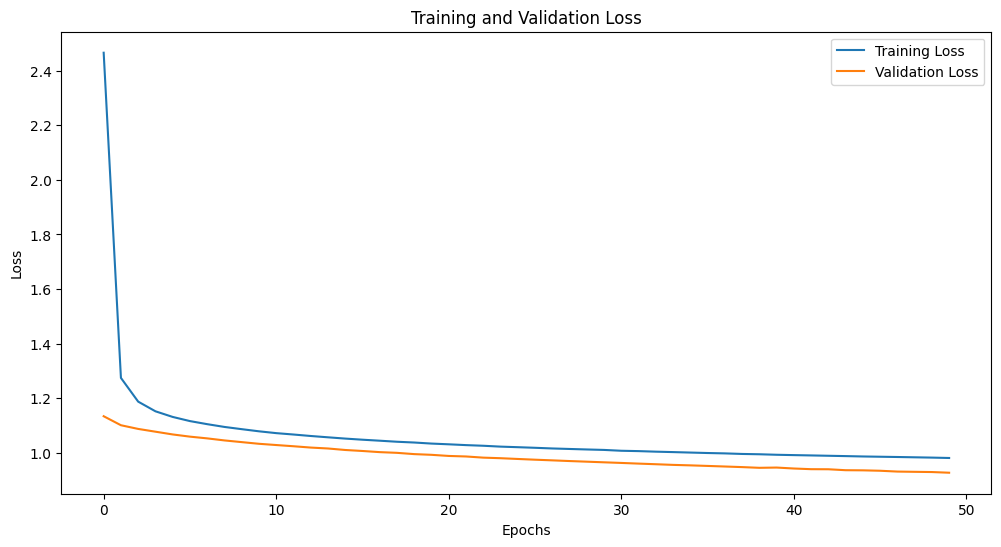

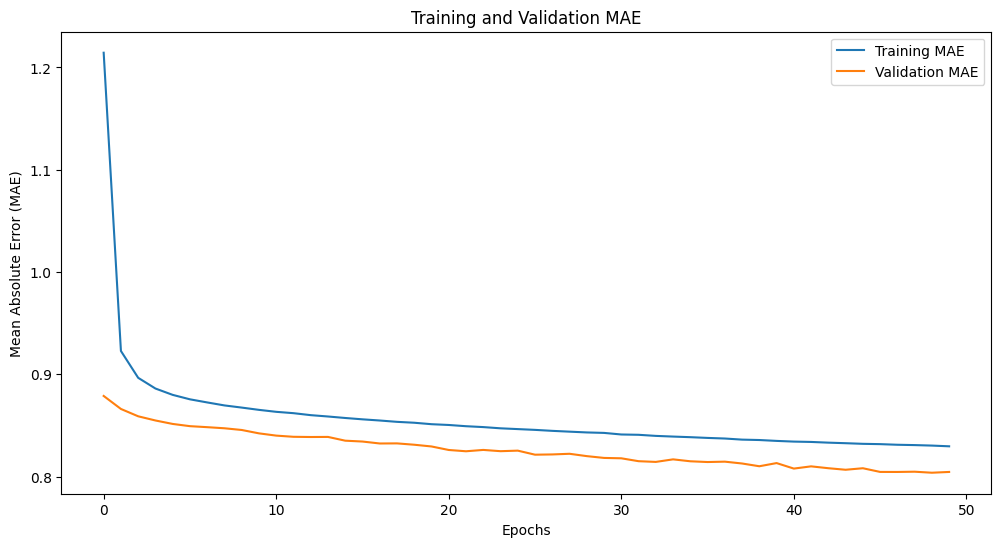

In [20]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.title('Training and Validation MAE')
plt.show()